In [14]:

from data.make_dataset import load_data
from alphas.alpha import FutureLookupStrategy
from alphas.backtest import Backtester

import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint     

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate basic strategy outputs

#### Load data

In [2]:
TS, BIDS, ASKS = load_data()

#### Data is one hour of non-equally spaced timestamps

In [4]:
pd.Series(TS)

0       2021-02-16 17:06:42.018319
1       2021-02-16 17:06:42.106023
2       2021-02-16 17:06:42.191776
3       2021-02-16 17:06:42.277234
4       2021-02-16 17:06:42.367687
                   ...            
39968   2021-02-16 18:06:41.577112
39969   2021-02-16 18:06:41.667519
39970   2021-02-16 18:06:41.759223
39971   2021-02-16 18:06:41.841185
39972   2021-02-16 18:06:41.919707
Length: 39973, dtype: datetime64[ns]

#### Run basic strategy
Looking up one value into the future.

Mark to market variable contains the following. If we're holding a position - we're multiplying it by bid (what we would sell it for).\
If we're holding cash - we're adding cash to the holding. 

Weights are assuming we're not fully invested - some % of portfolio (even marginal) is held in cash.

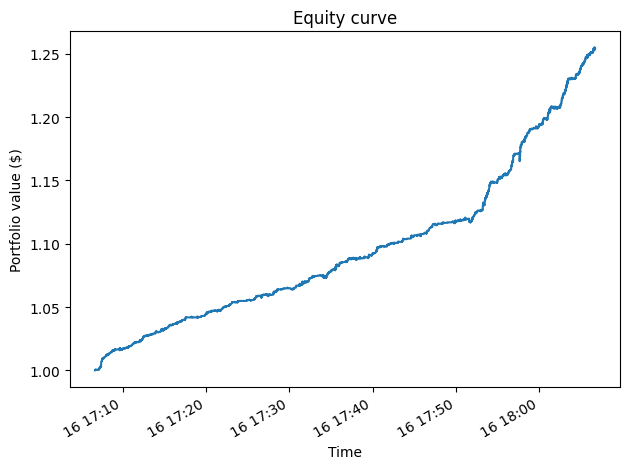


        Final cash value of portfolio 1.25

        First nonzero number of instruments held 17

        Final nonzero number of instruments held 22
        
    


/tmp/ipykernel_402525/1715579640.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Final cash value of portfolio {engine.equity_curve()[-1]:.2f}\n


In [13]:
engine = Backtester(TS, BIDS, ASKS, FutureLookupStrategy())
engine.run()


ax = engine.equity_curve().plot()          # returns the Axes
fig = ax.get_figure()                      # grab its Figure


# now display it if you still want the on‑screen preview
plt.title("Equity curve")
plt.ylabel("Portfolio value ($)")
plt.xlabel("Time")
plt.tight_layout()

fig.savefig("../reports/figures/equity_curve.png",           
            dpi=300,                    
            bbox_inches="tight")


plt.show()

print(
    f"""
        Final cash value of portfolio {engine.equity_curve()[-1]:.2f}\n
        First nonzero number of instruments held {list(filter(lambda x: x != 0, engine.positions))[0]}\n
        Final nonzero number of instruments held {list(filter(lambda x: x != 0, engine.positions))[-1]}
        
    """
)


#### Access equity curve

In [6]:
engine.equity_curve()

2021-02-16 17:06:42.018319    1.000000
2021-02-16 17:06:42.106023    1.000000
2021-02-16 17:06:42.191776    1.000000
2021-02-16 17:06:42.277234    1.000000
2021-02-16 17:06:42.367687    1.000000
                                ...   
2021-02-16 18:06:41.577112    1.254468
2021-02-16 18:06:41.667519    1.254798
2021-02-16 18:06:41.759223    1.254314
2021-02-16 18:06:41.841185    1.254908
2021-02-16 18:06:41.919707    1.254820
Length: 39973, dtype: float64

#### Access positions (number of instruments)

In [7]:
pd.Series(engine.positions, index=pd.to_datetime(TS[:len(engine.positions)]))

2021-02-16 17:06:42.018319     0
2021-02-16 17:06:42.106023     0
2021-02-16 17:06:42.191776     0
2021-02-16 17:06:42.277234     0
2021-02-16 17:06:42.367687     0
                              ..
2021-02-16 18:06:41.577112    22
2021-02-16 18:06:41.667519    22
2021-02-16 18:06:41.759223    22
2021-02-16 18:06:41.841185    22
2021-02-16 18:06:41.919707     0
Length: 39973, dtype: int64

## Trading stats

#### Print all stats

- Returns are annualized assume no cumulative reinvestment
- Turnover is in billions of times (frequently oscilate between 0 and ~100% weight in single instrument)
- Hitrate is odd to be below 50% but also assuming we're setting weight to 0% a lot - quite reasonable to have 0% returns frequently
- Sharpe, sortino and calmar are incredibly high as expected for biased strategy

In [8]:
pprint(engine.stats("desc"), compact=True, sort_dicts=False)
# pprint(engine.stats("prog"), compact=True, sort_dicts=False)

{'Annualized return (linear)': 24803.453197193317,
 'Annualized turnover (billion times)': 1.8893066468785364,
 'Max drawdown': 0.005904089264369079,
 'Hit rate': 0.7060094016008132,
 'Portfolio efficiency': 1.1390452487215796,
 'Annualized Sharpe': 1256.288757567864,
 'Sortino ratio': 1880.5743551860342,
 'Calmar ratio': 93.67962283621549}
